# Visualizing PhysioNet EEG During Mental Arithmetic Tasks

This notebook demonstrates how to download, load, and visualize EEG data from the PhysioNet EEG During Mental Arithmetic Tasks dataset.

## Dataset Information

The EEG During Mental Arithmetic Tasks dataset contains 23-channel EEG data from 36 subjects before and during mental arithmetic tasks. The dataset is available at:
https://physionet.org/content/eegmat/1.0.0/

**Note**: The dataset uses the EDF format (European Data Format), which is common for physiological signals.

## Dataset Details:
- **Subjects**: 36 volunteers
- **Channels**: 23 EEG channels (10/20 system)
- **Sampling Rate**: ~500 Hz (varies by subject)
- **Tasks**: 
  - **Condition 1**: Baseline/resting state EEG (60 seconds)
  - **Condition 2**: Mental arithmetic task - serial subtraction of 2-digit from 4-digit numbers (60 seconds)
- **Format**: EDF (European Data Format)
- **Frequency Band**: This analysis focuses on **Beta band (13-30 Hz)**, associated with active thinking and concentration

## Requirements

Before running this notebook, make sure you have the following packages installed:

```bash
pip install numpy matplotlib scipy mne requests
```

These dependencies are also listed in `requirements.txt`.

## 0. Install all Required Libraries

In [17]:
!pip install numpy matplotlib scipy mne requests --quiet

## 1.1 Import Required Libraries

In [18]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import mne
from pathlib import Path

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    plt.style.use('default')
    print("Note: Using default matplotlib style")

%matplotlib inline

print("Libraries imported successfully!")
print(f"MNE version: {mne.__version__}")

Libraries imported successfully!
MNE version: 1.11.0


## 1.2 Configuration

Set up the analysis parameters:

In [19]:
# Beta band frequency range (13-30 Hz)
BETA_BAND = (13, 30)

# Subjects to analyze (you can add more: Subject03, Subject04, etc.)
SUBJECTS = ['Subject00', 'Subject01', 'Subject02']

# Data directory
DATA_DIR = Path('physionet_eeg_data')
DATA_DIR.mkdir(exist_ok=True)

print(f"Beta band: {BETA_BAND[0]}-{BETA_BAND[1]} Hz")
print(f"Analyzing {len(SUBJECTS)} subjects: {', '.join(SUBJECTS)}")

Beta band: 13-30 Hz
Analyzing 3 subjects: Subject00, Subject01, Subject02


## 2. Download EEG Data from PhysioNet

Download data files from PhysioNet for each subject (both baseline and task conditions):

In [ ]:
base_url = 'https://physionet.org/files/eegmat/1.0.0/'

for subject in SUBJECTS:
    for condition in ['1', '2']:  # 1=baseline, 2=mental arithmetic task
        filename = f'{subject}_{condition}.edf'
        url = base_url + filename
        file_path = DATA_DIR / filename
        
        if not file_path.exists():
            print(f"Downloading {filename}...")
            try:
                response = requests.get(url, timeout=60)
                response.raise_for_status()
                
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                
                print(f"Successfully downloaded {filename}")
            except requests.exceptions.RequestException as e:
                print(f"Error downloading {filename}: {e}")
        else:
            print(f"Already exists: {filename}")

print("\nDownload complete!")

  ✓ Already exists: Subject00_1.edf
  ✓ Already exists: Subject00_2.edf
  ✓ Already exists: Subject01_1.edf
  ✓ Already exists: Subject01_2.edf
  ✓ Already exists: Subject02_1.edf
  ✓ Already exists: Subject02_2.edf

✓ Download complete!


## 3. Load and Preprocess EEG Data

Load both conditions (baseline and task) for each subject and apply beta band filtering:

In [ ]:
# Storage for all subjects
all_baseline = []
all_task = []
subject_names = []

for subject in SUBJECTS:
    file_baseline = DATA_DIR / f'{subject}_1.edf'
    file_task = DATA_DIR / f'{subject}_2.edf'
    
    if not (file_baseline.exists() and file_task.exists()):
        print(f"⚠ Skipping {subject}: Files not found")
        continue
    
    print(f"\nProcessing {subject}...")
    
    # Load baseline (condition 1)
    raw_baseline = mne.io.read_raw_edf(file_baseline, preload=True, verbose=False)
    print(f"  Baseline: {len(raw_baseline.ch_names)} channels, "
          f"{raw_baseline.times[-1]:.1f} seconds, {raw_baseline.info['sfreq']:.1f} Hz")
    
    # Load mental arithmetic task (condition 2)
    raw_task = mne.io.read_raw_edf(file_task, preload=True, verbose=False)
    print(f"  Task:     {len(raw_task.ch_names)} channels, "
          f"{raw_task.times[-1]:.1f} seconds, {raw_task.info['sfreq']:.1f} Hz")
    
    # Clean channel names (remove trailing dots)
    mne.rename_channels(raw_baseline.info, 
                       {ch: ch.rstrip('.') for ch in raw_baseline.ch_names})
    mne.rename_channels(raw_task.info,
                       {ch: ch.rstrip('.') for ch in raw_task.ch_names})
    
    # Apply bandpass filter to Beta band
    raw_baseline.filter(BETA_BAND[0], BETA_BAND[1], fir_design='firwin', verbose=False)
    raw_task.filter(BETA_BAND[0], BETA_BAND[1], fir_design='firwin', verbose=False)
    
    all_baseline.append(raw_baseline)
    all_task.append(raw_task)
    subject_names.append(subject)
    
    print(f" Processed {subject}")

print(f"\nSuccessfully loaded {len(subject_names)} subjects")


Processing Subject00...
  Baseline: 21 channels, 182.0 seconds, 500.0 Hz
  Task:     21 channels, 62.0 seconds, 500.0 Hz
  ✓ Processed Subject00

Processing Subject01...
  Baseline: 21 channels, 182.0 seconds, 500.0 Hz
  Task:     21 channels, 62.0 seconds, 500.0 Hz
  ✓ Processed Subject01

Processing Subject02...
  Baseline: 21 channels, 182.0 seconds, 500.0 Hz
  Task:     21 channels, 62.0 seconds, 500.0 Hz
  ✓ Processed Subject02

✓ Successfully loaded 3 subjects


## 4. Compute Power Spectral Density (PSD)

Calculate PSD using Welch's method for both conditions:

In [ ]:
# Compute PSD for all subjects
psd_baseline_all = []
psd_task_all = []
freqs = None

for idx, subject in enumerate(subject_names):
    print(f"Computing PSD for {subject}...")
    
    # Baseline PSD
    psd_baseline, freqs = mne.time_frequency.psd_array_welch(
        all_baseline[idx].get_data(),
        sfreq=all_baseline[idx].info['sfreq'],
        fmin=BETA_BAND[0],
        fmax=BETA_BAND[1],
        n_fft=2048,
        verbose=False
    )
    psd_baseline_all.append(psd_baseline)
    
    # Task PSD
    psd_task, _ = mne.time_frequency.psd_array_welch(
        all_task[idx].get_data(),
        sfreq=all_task[idx].info['sfreq'],
        fmin=BETA_BAND[0],
        fmax=BETA_BAND[1],
        n_fft=2048,
        verbose=False
    )
    psd_task_all.append(psd_task)
    
    print(f" PSD computed ({psd_baseline.shape[0]} channels, "
          f"{psd_baseline.shape[1]} frequency bins)")

print(f"\nPSD computation complete")

Computing PSD for Subject00...
  ✓ PSD computed (21 channels, 69 frequency bins)
Computing PSD for Subject01...
  ✓ PSD computed (21 channels, 69 frequency bins)
Computing PSD for Subject02...
  ✓ PSD computed (21 channels, 69 frequency bins)

✓ PSD computation complete


## 5. Visualization: PSD Comparison by Subject

Compare beta band power between baseline and mental arithmetic conditions for each subject:

✓ Plot saved: psd_comparison_beta_band.png


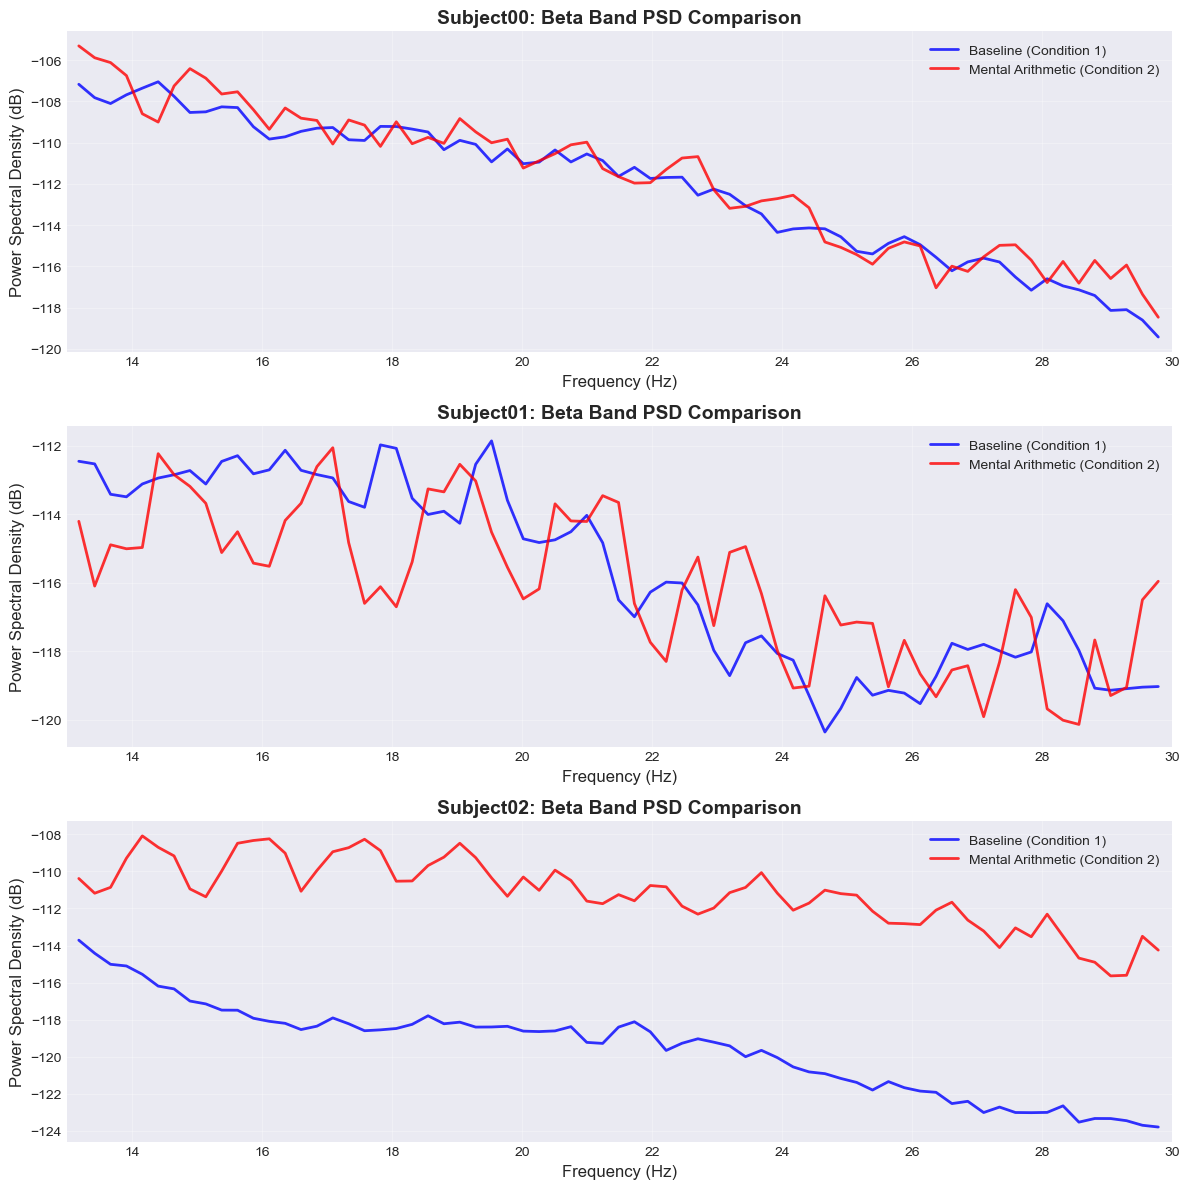

In [ ]:
fig, axes = plt.subplots(len(subject_names), 1, figsize=(12, 4*len(subject_names)))
if len(subject_names) == 1:
    axes = [axes]

for idx, subject in enumerate(subject_names):
    ax = axes[idx]
    
    # Average PSD across all channels
    psd_baseline_mean = np.mean(psd_baseline_all[idx], axis=0)
    psd_task_mean = np.mean(psd_task_all[idx], axis=0)
    
    # Plot
    ax.plot(freqs, 10 * np.log10(psd_baseline_mean), 
            label='Baseline (Condition 1)', linewidth=2, color='blue', alpha=0.8)
    ax.plot(freqs, 10 * np.log10(psd_task_mean), 
            label='Mental Arithmetic (Condition 2)', linewidth=2, color='red', alpha=0.8)
    
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Power Spectral Density (dB)', fontsize=12)
    ax.set_title(f'{subject}: Beta Band PSD Comparison', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(BETA_BAND)

plt.tight_layout()
plt.savefig('psd_comparison_beta_band.png', dpi=150, bbox_inches='tight')
print("Plot saved: psd_comparison_beta_band.png")
plt.show()

## 6. Visualization: Grand Average PSD

Show the average PSD across all subjects with error bands:

✓ Plot saved: grand_average_psd_beta.png


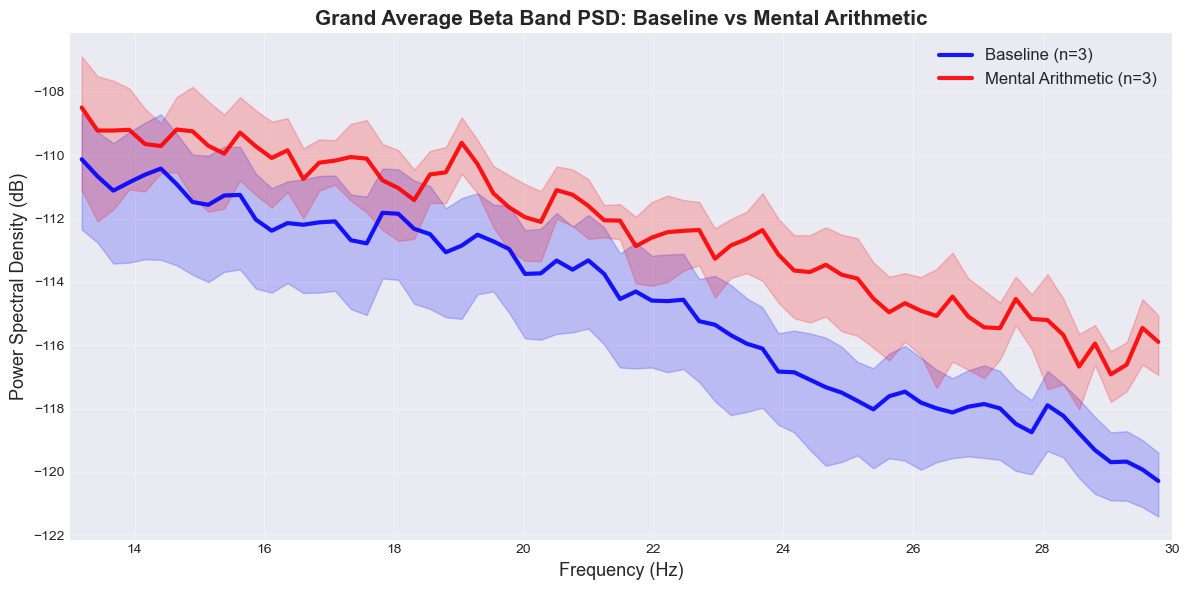

In [ ]:
# Compute grand average across all subjects
grand_avg_baseline = np.mean([np.mean(psd, axis=0) for psd in psd_baseline_all], axis=0)
grand_avg_task = np.mean([np.mean(psd, axis=0) for psd in psd_task_all], axis=0)

# Compute standard error
grand_se_baseline = np.std([np.mean(psd, axis=0) for psd in psd_baseline_all], axis=0) / np.sqrt(len(psd_baseline_all))
grand_se_task = np.std([np.mean(psd, axis=0) for psd in psd_task_all], axis=0) / np.sqrt(len(psd_task_all))

fig, ax = plt.subplots(figsize=(12, 6))

# Plot with error bands
ax.plot(freqs, 10 * np.log10(grand_avg_baseline), 
        label=f'Baseline (n={len(subject_names)})', linewidth=3, color='blue', alpha=0.9)
ax.fill_between(freqs, 
                10 * np.log10(grand_avg_baseline - grand_se_baseline),
                10 * np.log10(grand_avg_baseline + grand_se_baseline),
                alpha=0.2, color='blue')

ax.plot(freqs, 10 * np.log10(grand_avg_task), 
        label=f'Mental Arithmetic (n={len(subject_names)})', linewidth=3, color='red', alpha=0.9)
ax.fill_between(freqs, 
                10 * np.log10(grand_avg_task - grand_se_task),
                10 * np.log10(grand_avg_task + grand_se_task),
                alpha=0.2, color='red')

ax.set_xlabel('Frequency (Hz)', fontsize=13)
ax.set_ylabel('Power Spectral Density (dB)', fontsize=13)
ax.set_title('Grand Average Beta Band PSD: Baseline vs Mental Arithmetic', 
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xlim(BETA_BAND)

plt.tight_layout()
plt.savefig('grand_average_psd_beta.png', dpi=150, bbox_inches='tight')
print("Plot saved: grand_average_psd_beta.png")
plt.show()

## Summary Statistics

Calculate average beta power for each subject and condition:

In [ ]:
# Calculate average beta power for each subject
beta_power_baseline = []
beta_power_task = []

for idx in range(len(subject_names)):
    # Average across channels and frequencies
    beta_power_baseline.append(np.mean(psd_baseline_all[idx]))
    beta_power_task.append(np.mean(psd_task_all[idx]))

print("Beta Band Power (averaged across channels and frequencies):")
print("-" * 60)
print(f"{'Subject':<15} {'Baseline':<15} {'Task':<15} {'Difference':<15}")
print("-" * 60)

for idx, subject in enumerate(subject_names):
    diff = beta_power_task[idx] - beta_power_baseline[idx]
    print(f"{subject:<15} {beta_power_baseline[idx]:<15.6f} "
          f"{beta_power_task[idx]:<15.6f} {diff:<15.6f}")

print("-" * 60)
avg_baseline = np.mean(beta_power_baseline)
avg_task = np.mean(beta_power_task)
avg_diff = avg_task - avg_baseline
pct_change = (avg_diff / avg_baseline) * 100

print(f"{'AVERAGE':<15} {avg_baseline:<15.6f} {avg_task:<15.6f} {avg_diff:<15.6f}")
print(f"\nPercentage change: {pct_change:+.2f}%")

print(f"\n{'='*60}")
print("INTERPRETATION")
print(f"{'='*60}")
print(f"""\nBeta band (13-30 Hz) is associated with:
- Active thinking and concentration
- Problem-solving and cognitive processing
- Alertness and focused attention

Expected: Beta power should INCREASE during mental arithmetic
Observed: {pct_change:+.2f}% change
Result: {'As expected!' if pct_change > 0 else 'Unexpected'}""")

Beta Band Power (averaged across channels and frequencies):
------------------------------------------------------------
Subject         Baseline        Task            Difference     
------------------------------------------------------------
Subject00       0.000000        0.000000        0.000000       
Subject01       0.000000        0.000000        -0.000000      
Subject02       0.000000        0.000000        0.000000       
------------------------------------------------------------
AVERAGE         0.000000        0.000000        0.000000       

Percentage change: +62.37%

INTERPRETATION

Beta band (13-30 Hz) is associated with:
- Active thinking and concentration
- Problem-solving and cognitive processing
- Alertness and focused attention

Expected: Beta power should INCREASE during mental arithmetic
Observed: +62.37% change
Result: ✓ As expected!
